---

<div align='center'>
<font size="+2">

Text Mining and Natural Language Processing  
2023-2024

<b>SelectWise</b>

Alessandro Ghiotto 513944

</font>
</div>

---

# Notebook 1 - Count based methods:

1. Look at the Dataset
2. Representing documents with TF-IDF weighting:
    - Normal tf-idf
    - tf-idf truncated with SVD
    - tf-idf based retrieval from train set
3. n-gram LM based classification
---

I have chosen the QASC dataset from AllenAI. Each sample consist of a question, 8 multiple choices and two facts which gives information about the related question. I simplified the dataset task a bit, since it actually required the facts to be retrieved from a text corpus. The the multiple choice task can be seen as single-label multi-class classification between the possible alternatives. Here I have reported some information from the huggingface page <https://huggingface.co/datasets/allenai/qasc>.

**Dataset Summary:**

QASC is a question-answering dataset with a focus on sentence composition. It consists of 9,980 8-way multiple-choice questions about grade school science (8,134 train, 926 dev, 920 test), and comes with a corpus of 17M sentences.

**Data Fields:**

- `id`: a string feature.
- `question`: a string feature.
- `choices`: a dictionary feature containing:
    - `text`: a string feature.
    - `label`: a string feature.
- `answerKey`: a string feature.
- `fact1`: a string feature.
- `fact2`: a string feature.
- `combinedfact`: a string feature.
- `formatted_question`: a string feature.

**Example:**

    {
        "answerKey": "F",
        "choices": {
            "label": ["A", "B", "C", "D", "E", "F", "G", "H"],
            "text": ["sand", "occurs over a wide range", "forests", "Global warming", "rapid changes occur", "local weather conditions", "measure of motion", "city life"]
        },
        "combinedfact": "Climate is generally described in terms of local weather conditions",
        "fact1": "Climate is generally described in terms of temperature and moisture.",
        "fact2": "Fire behavior is driven by local weather conditions such as winds, temperature and moisture.",
        "formatted_question": "Climate is generally described in terms of what? (A) sand (B) occurs over a wide range (C) forests (D) Global warming (E) rapid changes occur (F) local weather conditions (G) measure of motion (H) city life",
        "id": "3NGI5ARFTT4HNGVWXAMLNBMFA0U1PG",
        "question": "Climate is generally described in terms of what?"
    }


**Citation Information:**

    @article{allenai:qasc,
        author    = {Tushar Khot and Peter Clark and Michal Guerquin and Peter Jansen and Ashish Sabharwal},
        title     = {QASC: A Dataset for Question Answering via Sentence Composition},
        journal   = {arXiv:1910.11473v2},
        year      = {2020},
    }


---
# **1. Look at the Dataset**

The dataset comes with 3 splits (train, validation and test), but the test set comes without any label, so I will not use it. I will use the validation split as the test set, and take a portion of the train as validation set. I will test the best model on the test set only at the end.

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import scipy

# load the qasc dataset from allenai (https://huggingface.co/datasets/allenai/qasc)
# it contains already train, validation and test splits
dataset = load_dataset("allenai/qasc")

seed = 8

# take a look
# 90% of the dataset is used for training, 10% for validation
n_val_samples = len(dataset['train']) // 10
n_train_samples = len(dataset['train']) - n_val_samples
margin = 5
for i in range(n_train_samples - margin, n_train_samples  + margin):
    print(f'sample {i} -', dataset['train'][i]['question'])


sample 7316 - What temperature are icebergs?
sample 7317 - what causes a solid to form?
sample 7318 - What causes ice to form?
sample 7319 - When water molecules expand, what do they begin to form?
sample 7320 - What freezes into ice?
sample 7321 - What happens when water's temperature drops to 32 degrees or below?
sample 7322 - Freezing causes what?
sample 7323 - What do animals feel when threatened?
sample 7324 - what kind of response does threatening behavior cause in animals?
sample 7325 - What can threatening behavior cause?


Since there are a lot of similar questions (questions are divided in groups by theme), I will take the val set from the train without shuffling. So that the val set give me a meaningful evaluation of the models on out of domain data.

In [2]:
# I pick this exact point because the theme in the question changes
n_first_val_sample = 7323
df_train = pd.DataFrame(dataset['train'][:n_first_val_sample])
df_val = pd.DataFrame(dataset['train'][n_first_val_sample:])
df_test = pd.DataFrame(dataset['validation'])

# Quick look at the data
print("num_rows train:", len(df_train))
print("num_rows val:", len(df_val))
print("num_rows test:", len(df_test))
print("columns :", df_train.columns)
# print an example
print("\nexample:\n", df_train.iloc[0])

num_rows train: 7323
num_rows val: 811
num_rows test: 926
columns : Index(['id', 'question', 'choices', 'answerKey', 'fact1', 'fact2',
       'combinedfact', 'formatted_question'],
      dtype='object')

example:
 id                                       3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K
question              What type of water formation is formed by clouds?
choices               {'text': ['pearls', 'streams', 'shells', 'diam...
answerKey                                                             F
fact1                 beads of water are formed by water vapor conde...
fact2                                   Clouds are made of water vapor.
combinedfact                    Beads of water can be formed by clouds.
formatted_question    What type of water formation is formed by clou...
Name: 0, dtype: object


For an easier handling of the data I create one column for each choice

From the column `choices` constituted by `{'text': ['pearls', ...], 'label':['A', ...]}` to 8 columns `["A", "B", "C", "D", "E", "F", "G", "H"]`

In [3]:
def format_choices(df):
    choices = df['choices'].apply(pd.Series)

    # Check if all labels are in the correct order
    # so we are sure of not swapping the labels of our choises
    correct_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    for labels in choices['label']:
        if labels != correct_order:
            raise ValueError(f"Labels are not in the correct order: {labels}")

    # Create new columns for each label
    for i, label in enumerate(correct_order):
        df[label] = choices['text'].apply(lambda x: x[i])

    # Drop the original 'choices' column
    df = df.drop(columns=['choices'])
    return df

df_train = format_choices(df_train)
df_val = format_choices(df_val)
df_test = format_choices(df_test) 
 
# Display the updated DataFrame
print(df_train.iloc[0])

id                                       3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K
question              What type of water formation is formed by clouds?
answerKey                                                             F
fact1                 beads of water are formed by water vapor conde...
fact2                                   Clouds are made of water vapor.
combinedfact                    Beads of water can be formed by clouds.
formatted_question    What type of water formation is formed by clou...
A                                                                pearls
B                                                               streams
C                                                                shells
D                                                              diamonds
E                                                                  rain
F                                                                 beads
G                                                               

At the end the main fields are:
- question
- our possible answers `["A", "B", "C", "D", "E", "F", "G", "H"]`
- the associated facts (`fact1` and `fact2`).

Now we can look at our data, all the following plots are computed only on the train data.

Here I look at the number of words that we have in each sample. Words are counted as the elements of the list given as output by `word_tokenize` (from `nltk.tokenize`), minus the punctuations.

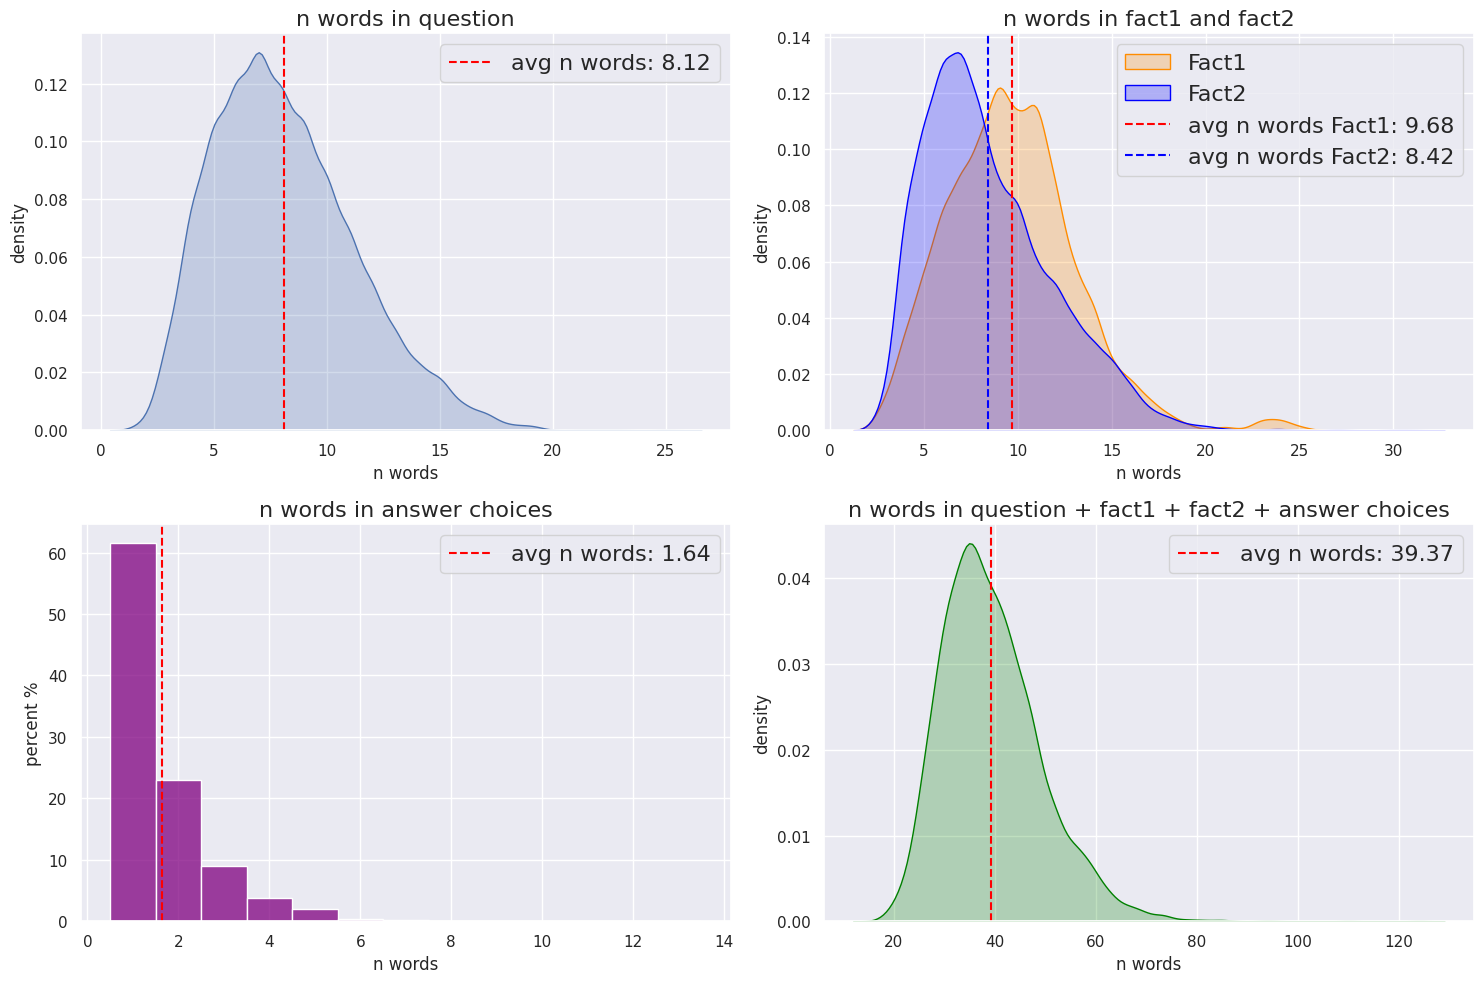

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from nltk.tokenize import word_tokenize
import string
punctuations = set(string.punctuation)

def get_words(sentence):
    # Lowercase all sentences
    sentence = sentence.lower()
    # Tokenize using nltk
    my_tokenized_tokens = word_tokenize(sentence)
    # Removing punctuations
    mywords = [word for word in my_tokenized_tokens if word not in punctuations]
    return mywords

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# KDE - number of words in question
question_nwords = [len(get_words(question)) for question in df_train['question']]
avg_question_nwords = np.mean(question_nwords)
sns.kdeplot(question_nwords, fill=True, ax=axes[0, 0])
axes[0, 0].axvline(avg_question_nwords, color='red', linestyle='--', label=f'avg n words: {avg_question_nwords:.2f}')
axes[0, 0].set_title('n words in question', fontsize=16)
axes[0, 0].set_xlabel('n words')
axes[0, 0].set_ylabel('density')
axes[0, 0].legend(prop={'size': 16})

# KDE - number of words in fact1 and fact2
fact1_nwords = [len(get_words(fact)) for fact in df_train['fact1']]
fact2_nwords = [len(get_words(fact)) for fact in df_train['fact2']]
avg_fact1_nwords = np.mean(fact1_nwords)
avg_fact2_nwords = np.mean(fact2_nwords)
sns.kdeplot(fact1_nwords, fill=True, ax=axes[0, 1], label='Fact1', color='darkorange')
sns.kdeplot(fact2_nwords, fill=True, ax=axes[0, 1], label='Fact2', color='blue')
axes[0, 1].axvline(avg_fact1_nwords, color='red', linestyle='--', label=f'avg n words Fact1: {avg_fact1_nwords:.2f}')
axes[0, 1].axvline(avg_fact2_nwords, color='blue', linestyle='--', label=f'avg n words Fact2: {avg_fact2_nwords:.2f}')
axes[0, 1].set_title('n words in fact1 and fact2', fontsize=16)
axes[0, 1].set_xlabel('n words')
axes[0, 1].set_ylabel('density')
axes[0, 1].legend(prop={'size': 16})

# KDE - number of words in answer choices
choice_nwords = [len(get_words(choice)) for choice in df_train[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']].values.flatten()]
avg_choice_nwords = np.mean(choice_nwords)
sns.histplot(choice_nwords, discrete=True, stat='percent', ax=axes[1, 0],  color='purple')
axes[1, 0].axvline(avg_choice_nwords, color='red', linestyle='--', label=f'avg n words: {avg_choice_nwords:.2f}')
axes[1, 0].set_title('n words in answer choices', fontsize=16)
axes[1, 0].set_xlabel('n words')
axes[1, 0].set_ylabel('percent %')
axes[1, 0].legend(prop={'size': 16})

# KDE - number of words in question + fact1 + fact2 + answer choices
from functools import reduce
columns = ['question', 'fact1', 'fact2', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
nwords_train = df_train[columns].apply(
    lambda row: len(get_words(reduce(lambda x, y: x + ' ' + y, row))), axis=1
)
avg_nwords_train = np.mean(nwords_train)
sns.kdeplot(nwords_train, fill=True, ax=axes[1, 1], color='green')
axes[1, 1].axvline(avg_nwords_train, color='red', linestyle='--', label=f'avg n words: {avg_nwords_train:.2f}')
axes[1, 1].set_title('n words in question + fact1 + fact2 + answer choices', fontsize=16)
axes[1, 1].set_xlabel('n words')
axes[1, 1].set_ylabel('density')
axes[1, 1].legend(prop={'size': 16})

# Adjust the layout
plt.tight_layout()
plt.show()

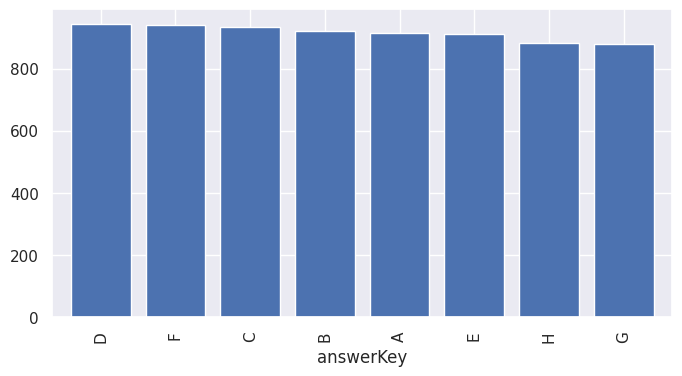

In [10]:
# LOOK AT THE BALANCE OF THE CLASSES
# Get the counts of each answerKey
answer_counts = pd.Series(df_train['answerKey']).value_counts()
# Plot the histogram of answerKey counts
plot = answer_counts.plot(kind='bar', figsize=(8, 4), width=0.8)

In [22]:
from functools import reduce

columns = ['question', 'fact1', 'fact2', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# get the number of words in each row (question + fact1 + fact2 + choices)
nwords_train = df_train[columns].apply(
    lambda row: len(get_words(reduce(lambda x, y: x + ' ' + y, row))), axis=1
)
nwords_val = df_val[columns].apply(
    lambda row: len(get_words(reduce(lambda x, y: x + ' ' + y, row))), axis=1
)
nwords_test = df_test[columns].apply(
    lambda row: len(get_words(reduce(lambda x, y: x + ' ' + y, row))), axis=1
)
print("total number of words in the train dataset :", sum(nwords_train))
print("total number of words in the val dataset   :", sum(nwords_val))
print("total number of words in the test dataset  :", sum(nwords_test))

total number of words in the train dataset : 288301
total number of words in the val dataset   : 31779
total number of words in the test dataset  : 35963


In [6]:
choices_one_word = [choice_nwords[i] == 1 for i in range(len(choice_nwords))]
max_len = max(choice_nwords)
print('number of choices costituted by a single word:', np.array(choices_one_word).sum())
print('number of choices costituted by more than one word:', len(choices_one_word) - np.array(choices_one_word).sum())
print('percentage of choices costituted by a single word:', round(np.array(choices_one_word).sum() / len(choices_one_word) * 100, 3), '%')
print('max number of words of a choice:', max_len)


number of choices costituted by a single word: 36042
number of choices costituted by more than one word: 22542
percentage of choices costituted by a single word: 61.522 %
max number of words of a choice: 13


So we have seen that:
- questions and facts are quite short (8/9 words on average)
- classes ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'] are balanced
- choices are short, but not all the possible answers are constituted by a single word


### Word Cloud

For building the word cloud I put together all the words seen in the train dataset (question + facts + choices), and I remove the stopwords.

In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))

def nltk_get_text(sentence):
    sentence = sentence.lower()
    my_tokenized_tokens = word_tokenize(sentence)
    # Removing stop words and punctuations
    mytokens = [word for word in my_tokenized_tokens if word not in stopwords_list and word not in punctuations]
    # join the tokens back into a single string
    sentence_preprocessed = ' '.join(mytokens)
    return sentence_preprocessed

samples = df_train['question'] + ' ' + df_train['fact1'] + ' ' + df_train['fact2'] + ' ' + \
          df_train['A'] + ' ' + df_train['B'] + ' ' + df_train['C'] + ' ' + df_train['D'] + ' ' + \
          df_train['E'] + ' ' + df_train['F'] + ' ' + df_train['G'] + ' ' + df_train['H']

text_preprocessed = samples.apply(nltk_get_text)
print(text_preprocessed[0])
text = ' '.join(text_preprocessed)
print('number of words in the text:', len(text.split()))


[nltk_data] Downloading package stopwords to /home/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


type water formation formed clouds beads water formed water vapor condensing clouds made water vapor pearls streams shells diamonds rain beads cooled liquid
number of words in the text: 195201


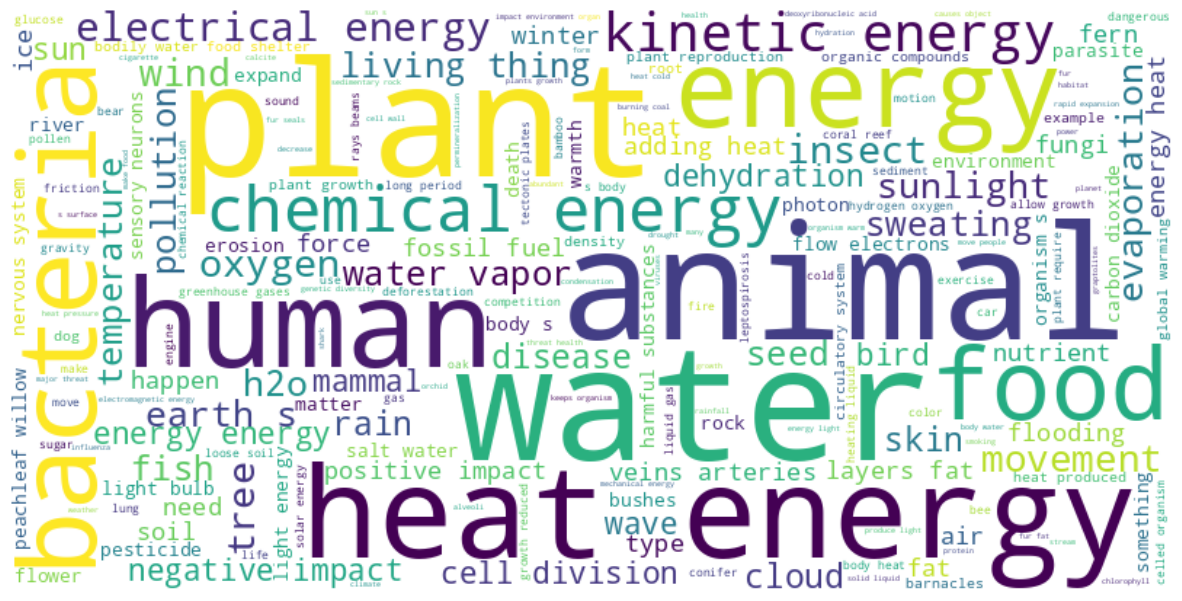

In [31]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


---

# **Representing documents with TF-IDF weighting**

TF-IDF is a widely used technique in NLP for information retrieval and document classification. The TF-IDF method create a vector representation of a document based on the occurrence of the terms in our documents. The idea is that you can compare two documents by **computing the cosine similarity between the TF-IDF representation of this documents**. In mine multiple choice settings, I will pick as answer the choice with highest cosine similarity with our question (+ the annexed facts).

As preprocessing I perform:
- **Stop Word Removal**
- **Stemming**
- plus others like removing punctuation and lowercase the characters

Because at the end TF-IDF is just a count based representation, it can't really "read the sentence" like a RNN/TransformerEncoder would do, so stop words aren't really useful. In the same way with tf-idf we care just about of what words are present, and not for example the inflections of this words (so we can just use the stem of our words).

I treat the choices as normal documents and compute on it the TF-IDF weights, even if at the end also using simple BoW would be very similar, since 60% of this choices are single words. Given that we will compute the cosine similarity, for a document of a single word we get all zeros except for one value (so the intensity of this value is meaningless while computing the cosine similarity)

![picture](../imgs/1_tfidf.png)

### Normal tf-idf

In [18]:
# Concatenate 'fact1', 'fact2', and 'question' into 'facts_and_question'
df_train['facts_and_question'] = df_train['fact1'] + ' ' + df_train['fact2'] + ' ' + df_train['question']
df_val['facts_and_question'] = df_val['fact1'] + ' ' + df_val['fact2'] + ' ' + df_val['question']
df_test['facts_and_question'] = df_test['fact1'] + ' ' + df_test['fact2'] + ' ' + df_test['question']

print(df_train['facts_and_question'].iloc[0])
print(df_train['facts_and_question'].iloc[1])

beads of water are formed by water vapor condensing Clouds are made of water vapor. What type of water formation is formed by clouds?
beads of water are formed by water vapor condensing Condensation is the change of water vapor to a liquid. Where do beads of water come from?


Create the **tokenizer** and apply it to the new column 'facts_and_question' and to all of our multiple choices 'A', 'B'...

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))
punctuations = set(string.punctuation)
porter = PorterStemmer()

def nltk_tokenizer(sentence):
    # Lowercase all sentences
    sentence = sentence.lower()

    # Tokenize using nltk
    my_tokenized_tokens = word_tokenize(sentence)

    # Removing stop words and punctuations
    mytokens = [word for word in my_tokenized_tokens if word not in stopwords_list and word not in punctuations]

    # Stemming
    mytokens = [porter.stem(word) for word in mytokens]

    # join the tokens back into a single string
    sentence_preprocessed = ' '.join(mytokens)

    return sentence_preprocessed


# Define the custom transformer
tokenizer_transformer = FunctionTransformer(lambda x: x.apply(nltk_tokenizer).to_frame(), validate=False)
# List of columns to apply the tokenizer to
columns_to_tokenize = ['facts_and_question', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# Create the column transformer
dataframe_tokenizer = ColumnTransformer(
    transformers=[
        (col, tokenizer_transformer, col) for col in columns_to_tokenize
    ],
    remainder='drop'  # drop other columns
)

# Apply the column transformer to the DataFrame and convert the result to a DataFrame
df_train_tfidf = pd.DataFrame(dataframe_tokenizer.fit_transform(df_train), columns=columns_to_tokenize)
df_val_tfidf = pd.DataFrame(dataframe_tokenizer.fit_transform(df_val), columns=columns_to_tokenize)
df_test_tfidf = pd.DataFrame(dataframe_tokenizer.fit_transform(df_test), columns=columns_to_tokenize)

df_train_tfidf.iloc[0]

[nltk_data] Downloading package punkt to /home/max/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


facts_and_question    bead water form water vapor condens cloud made...
A                                                                 pearl
B                                                                stream
C                                                                 shell
D                                                               diamond
E                                                                  rain
F                                                                  bead
G                                                                  cool
H                                                                liquid
Name: 0, dtype: object


Let's create the **tf-idf** representation

1.   Decide our vocabulary (here a set with all the words in the train)
2.   Build the tf-idf sparse matrix (with sklearn)

We must use the same vocabulary from the train dataset, also for the val and test set


In [20]:
# first we need to define the vocabulary using the training data only!

# Combine all columns into a single text for each row
# (I take also the 'choices' for building the vocabulary)
combined_text_series = df_train_tfidf.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Define the vocabulary using the combined text
vocab = set()
for sent in combined_text_series:
    for word in sent.split(" "):
        vocab.add(word.strip())

print('Vocabulary size: N =', len(vocab)) # quite small vocabulary

Vocabulary size: N = 6467


In [21]:
from sklearn.feature_extraction.text import CountVectorizer # to create a bag of words
from sklearn.feature_extraction.text import TfidfTransformer # to create a tf-idf
from sklearn.pipeline import Pipeline

# first I vectorize the text (sentence -> BoW)
# then I apply the tf-idf transformation
pipeline_tfidf = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True, vocabulary=vocab)),
    ('tfidf', TfidfTransformer())
])

def apply_pipeline(pipeline, data):
    # Apply the pipeline to each column of df and store the results in a dictionary
    # so we store easily the results (which are sparse matrices)
    transformed_data = {}
    for col in data.columns:
        transformed_data[col] = pipeline.fit_transform(data[col])
    return transformed_data

# apply the pipeline to the training data
df_train_tfidf = apply_pipeline(pipeline_tfidf, df_train_tfidf)
df_val_tfidf = apply_pipeline(pipeline_tfidf, df_val_tfidf)
df_test_tfidf = apply_pipeline(pipeline_tfidf, df_test_tfidf)

# check the shape of the transformed data
# a (sparse) vector of size N (vocabulary size) for each row
print(df_train_tfidf['facts_and_question'].shape)
# we can see that our vectors are very sparse
print(df_train_tfidf['facts_and_question'][0])


(7323, 6467)
  (0, 568)	0.299258455897113
  (0, 1125)	0.47658398863925483
  (0, 1232)	0.20662566823088374
  (0, 2332)	0.2733387319225341
  (0, 2334)	0.26476923117270423
  (0, 3421)	0.18046099755032013
  (0, 6047)	0.1780272690223498
  (0, 6176)	0.4236651908701844
  (0, 6294)	0.5020448479196142


In [22]:
# Compute cosine similarity between two vectors (not pairwise like sklearn)
def cosine_similarity_btw2vec(v1, v2):
    # Check if the vectors are sparse matrices
    if scipy.sparse.issparse(v1):
        v1 = v1.toarray().flatten()
    if scipy.sparse.issparse(v2):
        v2 = v2.toarray().flatten()
    # v1 and v2 are two numpy arrays
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0 
    return dot_product / (norm_v1 * norm_v2)

# Compute cosine similarity between 'facts_and_question' and each choice column
similarity_scores = {}
for choice in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    # Compute cosine similarities
    # before I had sparse matrices, before of computing the cosine similarity I need to convert them to dense arrays
    similarity_scores[choice] = np.array([cosine_similarity_btw2vec(v1, v2) \
                                          for v1, v2 in zip(df_train_tfidf['facts_and_question'], df_train_tfidf[choice])])
similarity_scores = pd.DataFrame(similarity_scores)

# Display the similarity scores for the first row
print('shape from one entry of the dict:', similarity_scores['A'].shape)
print('the i-th value of one of the entries is the cosie similarity between the facts_and_question and that choice, for the i-th row of the dataset')
for choice, scores in similarity_scores.items():
    print(f"Cosine similarity between 'facts_and_question' and '{choice}' for the first row: {scores[0]}")

shape from one entry of the dict: (7323,)
the i-th value of one of the entries is the cosie similarity between the facts_and_question and that choice, for the i-th row of the dataset
Cosine similarity between 'facts_and_question' and 'A' for the first row: 0.0
Cosine similarity between 'facts_and_question' and 'B' for the first row: 0.0
Cosine similarity between 'facts_and_question' and 'C' for the first row: 0.0
Cosine similarity between 'facts_and_question' and 'D' for the first row: 0.0
Cosine similarity between 'facts_and_question' and 'E' for the first row: 0.0
Cosine similarity between 'facts_and_question' and 'F' for the first row: 0.29925845589711303
Cosine similarity between 'facts_and_question' and 'G' for the first row: 0.0
Cosine similarity between 'facts_and_question' and 'H' for the first row: 0.0


This means that in the first sample, only the word contained in choice F appears in the question, and we will pick this answer as predicted one from the model.

In [23]:
from sklearn.metrics import accuracy_score, f1_score

np.random.seed(seed)

def tfidf_predict(df_tfidf, print_n_random_choices=False):
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

    # compute cosine similarity between 'facts_and_question' and each choice column
    similarity_scores = {}
    for choice in choices:
        similarity_scores[choice] = np.array([cosine_similarity_btw2vec(v1, v2) \
                                              for v1, v2 in zip(df_tfidf['facts_and_question'], df_tfidf[choice])])
    # convert the dictionary to a DataFrame (so we navigate along the rows)
    similarity_scores = pd.DataFrame(similarity_scores)
    # find the choice with the highest cosine similarity
    # since we have a pandas DataFrame, the argmax returns the column name ('A', 'B', 'C', ...)
    predicted_choices = similarity_scores.idxmax(axis=1)

    # check if the sum of the cosine similarities is 0 for some rows (if are all 0, we choose a choice at random)
    sum_similarity = similarity_scores.sum(axis=1)
    for i, sum_sim in enumerate(sum_similarity):
        if sum_sim == 0:
            # for those rows, we choose a choices at random
            predicted_choices[i] = np.random.choice(choices)

    if print_n_random_choices:
        print('number of choices that are randomly chosen:', np.sum([sum_similarity == 0]))
    
    return predicted_choices


def evaluate_predictions(true_labels, predictions, dataset_label=None):
    # dataset_label is a string that specifies the dataset
    # {'train', 'validation', 'test'}

    # Compute accuracy and F1 score
    accuracy = accuracy_score(true_labels, predictions)
    # we don't care too much about the 'average' method, since the classes are balanced
    f1 = f1_score(true_labels, predictions, average='macro')
    
    print(f"{dataset_label} Accuracy:", accuracy)
    print(f"{dataset_label} F1 Score:", f1)
    return accuracy, f1


pred_train_tfidf = tfidf_predict(df_train_tfidf, print_n_random_choices=True)
train_accuracy, train_f1 = evaluate_predictions(df_train['answerKey'], pred_train_tfidf, 'train')

print('')
pred_val_tfidf = tfidf_predict(df_val_tfidf, print_n_random_choices=True)
val_accuracy, val_f1 = evaluate_predictions(df_val['answerKey'], pred_val_tfidf, 'validation')

number of choices that are randomly chosen: 136
train Accuracy: 0.8807865628840639
train F1 Score: 0.8806679268854758

number of choices that are randomly chosen: 36
validation Accuracy: 0.8668310727496917
validation F1 Score: 0.8657062870910568


We get as accuracy approximately 0.866, this means that the questions are quite easy... because when we take the argmax of the cosine similarity between tf-idf representations, it's like picking the answer which matches more (relevant) words with the question.

### tf-idf truncated with SVD

Now we can try to truncate the tf-idf matrix with **SVD**, and see if we get a more meaningful cosine similarity in a lower dimensional space. It make sense to try this since our multiple choices are particularly sparse, resulting in a cosine similarity with the question equal to 0 in the majority of the cases.

Let's try with `n_components = 200, 50, 10`

![picture](../imgs/1_tfidf_truncatedSVD.png)

In [24]:
from sklearn.decomposition import TruncatedSVD

def truncate_svd(df_tfidf, n_components=100):
    columns_to_combine = df_tfidf.keys()

    # Initialize the TruncatedSVD transformer
    svd = TruncatedSVD(n_components=n_components)

    # Stack all tfidf matrixes vertically
    stacked_matrix = np.vstack([df_tfidf[col].toarray() for col in columns_to_combine])

    # Apply SVD to the stacked matrix
    transformed_matrix = svd.fit_transform(stacked_matrix)

    # Split the transformed matrix back into individual columns
    split_indices = np.cumsum([df_tfidf[col].shape[0] for col in columns_to_combine])
    split_matrices = np.vsplit(transformed_matrix, split_indices[:-1])

    # Create a dictionary to store the transformed data
    transformed_data = {col: split_matrices[i] for i, col in enumerate(columns_to_combine)}

    return transformed_data

# Apply the SVD transformation to the training data
df_train_svd = truncate_svd(df_train_tfidf, n_components=200)
df_val_svd = truncate_svd(df_val_tfidf, n_components=200)

# check the shape of the transformed data
# a vector of size n_components for each row
print('truncated shape of the tfidf matrix:', df_train_svd['facts_and_question'].shape)
# we can see that our vectors are not sparse anymore
print('new representation:', df_train_svd['facts_and_question'][0][:10], '...')


# lets see the predcitons with the truncated SVD
# n_components = 200
print('\n', '---'*20, '\n')
print('predictions with truncated SVD (n_components=200):')
pred_train_svd = tfidf_predict(df_train_svd)
pred_val_svd = tfidf_predict(df_val_svd)
train_accuracy_svd, train_f1_svd = evaluate_predictions(df_train['answerKey'], pred_train_svd, 'train')
val_accuracy_svd, val_f1_svd = evaluate_predictions(df_val['answerKey'], pred_val_svd, 'validation')

#------------------------------------------------------------
# n_components = 50
print('\n', '---'*20, '\n')
print('predictions with truncated SVD (n_components=50):')
df_train_svd = truncate_svd(df_train_tfidf, n_components=50) # Truncated SVD on tfidf
df_val_svd = truncate_svd(df_val_tfidf, n_components=50)
pred_train_svd = tfidf_predict(df_train_svd) # predict
pred_val_svd = tfidf_predict(df_val_svd)
train_accuracy_svd, train_f1_svd = evaluate_predictions(df_train['answerKey'], pred_train_svd, 'train') # evaluate
val_accuracy_svd, val_f1_svd = evaluate_predictions(df_val['answerKey'], pred_val_svd, 'validation')

#------------------------------------------------------------
# n_components = 10
print('\n', '---'*20, '\n')
print('predictions with truncated SVD (n_components=10):')
df_train_svd = truncate_svd(df_train_tfidf, n_components=10) # Truncated SVD on tfidf
df_val_svd = truncate_svd(df_val_tfidf, n_components=10)
pred_train_svd = tfidf_predict(df_train_svd) # predict
pred_val_svd = tfidf_predict(df_val_svd)
train_accuracy_svd, train_f1_svd = evaluate_predictions(df_train['answerKey'], pred_train_svd, 'train') # evaluate
val_accuracy_svd, val_f1_svd = evaluate_predictions(df_val['answerKey'], pred_val_svd, 'validation')

truncated shape of the tfidf matrix: (7323, 200)
new representation: [ 0.00387925  0.0151613   0.09409047  0.03829091  0.53062513 -0.00525099
 -0.02615196 -0.00337864 -0.00468535  0.0010627 ] ...

 ------------------------------------------------------------ 

predictions with truncated SVD (n_components=200):
train Accuracy: 0.7880650006827803
train F1 Score: 0.7880221922469894
validation Accuracy: 0.8347718865598027
validation F1 Score: 0.8332368125257532

 ------------------------------------------------------------ 

predictions with truncated SVD (n_components=50):
train Accuracy: 0.6349856616140925
train F1 Score: 0.6349486078928741
validation Accuracy: 0.7274969173859432
validation F1 Score: 0.726371240936494

 ------------------------------------------------------------ 

predictions with truncated SVD (n_components=10):
train Accuracy: 0.43179024989758297
train F1 Score: 0.43171290395967105
validation Accuracy: 0.5203452527743526
validation F1 Score: 0.5173385964665407


At the end we got the best result without applying the truncated SVD, with normal tf-idf representation. While we decrease the number fo components `n_components` the accuracy decreases and decreases. 

### tf-idf based retrieval from train set

Instead of looking at the similarity between the answer and the question, I look at the similarity between the target sample and the questions in the train set (which I'm using like a database), than I take the answer from that question (I take the most similar between the possible choices from the current sample).

![picture](../imgs/1_tfidf_retrieval.png)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# df_train_tfidf: dictionary with the following keys: 'facts_and_question', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'
# each key contains a matrix of shape (n_samples, vocabulary_size)
# each row is the tf-idf representation of that sample

def retrieval_based_tfidf_predict(df_tfidf_target, df_tfidf_database, print_n_random_choices=False):
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    predicted_answer_keys = []
    n_choises_picked_randomly = 0

    # for each sample
    for i in range(df_tfidf_target['facts_and_question'].shape[0]):
        # cos similarity between the target question and all the questions in the database
        # here I use the pairwise cosine similarity between the target question and all the questions in the database
        questions_similarity = cosine_similarity(df_tfidf_target['facts_and_question'][i], df_tfidf_database['facts_and_question']).flatten()
        questions_similarity[i] = 0 # I don't want to consider the similarity with the target question
        # take the most similar question
        most_similar_question_idx = np.argmax(questions_similarity)
        # take the corresponding correct answer
        retrieved_answerKey = df_tfidf_database['answerKey'].iloc[most_similar_question_idx]
        retrieved_answer = df_tfidf_database[retrieved_answerKey][most_similar_question_idx]
        # compute the similarity between the correct answer and all the possible choices of the target question
        all_retrieved_choices = []
        for choice in choices:
            all_retrieved_choices.append(df_tfidf_target[choice][i].toarray().flatten())
        choices_similarity = cosine_similarity(retrieved_answer, all_retrieved_choices).flatten()
        # take the most similar choice
        most_similar_choice_idx = np.argmax(choices_similarity)
        best_choice = choices[most_similar_choice_idx]

        # if the max similarity is 0, we choose a choice at random
        max_similarity = choices_similarity[most_similar_choice_idx]
        if max_similarity == 0:
            n_choises_picked_randomly += 1
            best_choice = np.random.choice(choices)
        predicted_answer_keys.append(best_choice)

    if print_n_random_choices:
        print('number of choices that are randomly chosen:', n_choises_picked_randomly, 'out of', len(predicted_answer_keys))

    return predicted_answer_keys

# add the answerKey for the train, used for the retrieval
df_train_tfidf['answerKey'] = df_train['answerKey']

# predictions with retrieval-based method
print('predictions with retrieval-based method:')
pred_train_retrieval = retrieval_based_tfidf_predict(df_train_tfidf, df_train_tfidf, print_n_random_choices=True)
train_accuracy_retrieval, train_f1_retrieval = evaluate_predictions(df_train['answerKey'], pred_train_retrieval, 'train')

pred_val_retrieval = retrieval_based_tfidf_predict(df_val_tfidf, df_train_tfidf, print_n_random_choices=True)
val_accuracy_retrieval, val_f1_retrieval = evaluate_predictions(df_val['answerKey'], pred_val_retrieval, 'validation')


predictions with retrieval-based method:
number of choices that are randomly chosen: 5047 out of 7323
train Accuracy: 0.3092994674313806
train F1 Score: 0.30920704738528265
number of choices that are randomly chosen: 682 out of 811
validation Accuracy: 0.2059186189889026
validation F1 Score: 0.20536619337352907


In this dataset I don't have enough samples for this approach, in fact we can see that a lot of choices were picked randomly. And also from the dataset we can see that we have similar questions on the same topic, but which are slightly different, this can create 'confusion' to our tf-idf model. From the first samples of the train set we have:

In [26]:
for i in range(8):
    print('{:56}'.format(df_train['question'][i]), '-> ANSWER:', df_train[df_train['answerKey'][i]][0])

What type of water formation is formed by clouds?        -> ANSWER: beads
Where do beads of water come from?                       -> ANSWER: rain
What forms beads of water?                               -> ANSWER: streams
what kind of beads are formed from vapor condensing?     -> ANSWER: shells
what kind of beads are formed by their vapor condensing? -> ANSWER: pearls
What happens to the heat energy during condensation.     -> ANSWER: pearls
Vapor doing what forms beads of liquid?                  -> ANSWER: streams
Beads of water are formed when?                          -> ANSWER: liquid


Even if tf-idf is just a count base method, we have obtained quite good results

---

# **n-gram LM based classification**

n-gram Language Models generate the following word given as context the **n - 1 preceding words**. Given our question, instead of picking one of the most probable following words between the whole dictionary, I will get the **most probable between our alternatives** (the possible choices), it's like using a very simple decoder-only model. For training the n-gram LM I will use the columns `'question'`, `'fact1'`, `'fact2'` of the dataset

I will apply the same preprocessing that I have used for the "tf-idf part" (**Stop Words Removal**, **Stemming**). Since the context of a n-gram model is very short (n-1 words) I remove the stop words for not removing space from meaningful words. We can do it because we are not using the LM for generating text, we want just to pick the most reasonable between the choices. For the same reason we can stem the words, since we are not really continuating a sentence, here grammar will not help us (since the question is separated from the asnwer).

I will train a **3-gram LM**, since a lower n-gram have a too small context window size, but at the same time a bigger context window requires much more data (sparsity problem).

![picture](../imgs/1_ngramLM.png)

In [27]:
# tokenizer_transformer : our function that tokenizes the text (sklearn transformer for pandas DataFrame) 
# List of columns to apply the tokenizer to
columns_to_tokenize = ['question', 'fact1', 'fact2','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# Create the column transformer
dataframe_tokenizer = ColumnTransformer(
    transformers=[
        (col, tokenizer_transformer, col) for col in columns_to_tokenize
    ],
    remainder='drop'  # drop other columns
)

# Apply the column transformer to the DataFrame and convert the result to a DataFrame
df_train_ngram = pd.DataFrame(dataframe_tokenizer.fit_transform(df_train), columns=columns_to_tokenize)


I check that all the first words are different between the 8 possible choices (for each sample)

In [28]:
# take the first word for each choice
choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
df_train_ngram[choices] = df_train_ngram[choices].apply(lambda x: x.str.split().str[0])

# Function to check if all words are unique
def all_unique_words(row):
    words = row.tolist()
    return len(words) == len(set(words))

# Apply the function to each row
all_diff = df_train_ngram[choices].apply(all_unique_words)

all_diff = np.array(all_diff).sum().sum()
print('number of samples in which appears two choices starting with the same word:', all_diff)

number of samples in which appears two choices starting with the same word: 0


Since all the 8 choices (for each sample) start with a different word, I will use just this starting word, when I'm going to retrieve the answer.

**train**: learn the probabilities of the trigram lm on the `'question'`, `'fact1'`, `'fact2'` of the dataset. Each entry of this columns, for each sample, will be treated as a sentence.

**predict**: take the last 2 words of the question (`w1` and `w2`), and than compute the probability $P(w_3 | w_1, w_2)$, for each `w3` in the 8 possible choices that we have for this sample (`w3` is the *first word* of the choice).

In the prediction phase the facts aren't used, the information stored in such facts are implicitly used by the n-gram language model

In [29]:
from nltk import trigrams
from collections import defaultdict

# Stack the columns into a single column (our data -> a list of sentences)
sentences = df_train_ngram[['question', 'fact1', 'fact2']].stack().reset_index()
sentences = sentences[0] # take the column with the sentences
sentences = sentences.apply(lambda x: x.split())
print('number of sentences:', len(sentences))
print('total number of words:', sum([len(sentence) for sentence in sentences]))
print('example of a sentence:', sentences[0])

# Create a placeholder for model
trigram_model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance
for sentence in sentences:
    #sentence = ["this", "is", "a", "sentence","."]
    #sentence = ["None", "None", "this", "is", "a", "sentence",".", "None", "None"]
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
        trigram_model[(w1, w2)][w3] += 1

# Let's transform the counts to probabilities
for w1_w2 in trigram_model:
    total_count = float(sum(trigram_model[w1_w2].values()))
    for w3 in trigram_model[w1_w2]:
        trigram_model[w1_w2][w3] /= total_count

print('total number of trigrams seen by the model:', sum([len(trigram_model[w1_w2]) for w1_w2 in trigram_model]))
print('P(w3 | "water", "format")  -> ', dict(trigram_model['water', 'format']).items())
 

number of sentences: 21969
total number of words: 112736
example of a sentence: ['type', 'water', 'format', 'form', 'cloud']
total number of trigrams seen by the model: 52580
P(w3 | "water", "format")  ->  dict_items([('form', 0.5), ('rain', 0.5)])


In [30]:
seed = 8
np.random.seed(seed)

# function to get the best choice
def predict_trigramLM(df, model):
    
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    predicted_answer_keys = []
    n_choises_picked_randomly = 0

    for i in range(df.shape[0]):
        # take the last two words of the question
        question = df['question'][i].split()
        question = ['None', 'None'] + question # pad on the left
        w1, w2 = question[-2], question[-1]
        # take the choices
        all_retrieved_choices = []
        for choice in choices:
            all_retrieved_choices.append(df[choice][i])

        # compute the probability of each choice
        best_choice = None
        best_prob = 0
        for choice in all_retrieved_choices:
            prob = model[(w1, w2)][choice]
            if prob > best_prob:
                best_prob = prob
                best_choice = choice

        # if the max probability is 0, we choose a choice at random
        if best_prob == 0:
            n_choises_picked_randomly += 1
            best_choice_answerKey = np.random.choice(choices)
        else:
            # get the answerKey
            best_choice_index = all_retrieved_choices.index(best_choice)
            best_choice_answerKey = choices[best_choice_index]
        
        predicted_answer_keys.append(best_choice_answerKey)

    print('number of choices that are randomly chosen:', n_choises_picked_randomly, 'out of', len(predicted_answer_keys))
    return predicted_answer_keys

In [31]:
# predictions with n-gram language model
print('predictions with n-gram language model (TRAIN SET):')
pred_train_ngramLM = predict_trigramLM(df_train_ngram, trigram_model)
train_accuracy_ngramLM, train_f1_ngramLM = evaluate_predictions(df_train['answerKey'], pred_train_ngramLM, 'train')

# validation set
print('\npredictions with n-gram language model (VALIDATION SET):')
df_val_ngram = pd.DataFrame(dataframe_tokenizer.fit_transform(df_val), columns=columns_to_tokenize)
df_val_ngram[choices] = df_val_ngram[choices].apply(lambda x: x.str.split().str[0])
pred_val_ngramLM = predict_trigramLM(df_val_ngram, trigram_model)
val_accuracy_ngramLM, val_f1_ngramLM = evaluate_predictions(df_val['answerKey'], pred_val_ngramLM, 'validation')



predictions with n-gram language model (TRAIN SET):
number of choices that are randomly chosen: 6436 out of 7323


train Accuracy: 0.1697391779325413
train F1 Score: 0.16981919976327065

predictions with n-gram language model (VALIDATION SET):
number of choices that are randomly chosen: 756 out of 811
validation Accuracy: 0.15413070283600494
validation F1 Score: 0.15400829843303115


we can see that most of the choices are picked randomly, and in the validation set is even worse, since the questions and facts from the validation set wasn't seen by the model during training time. Let's see if with a **bigrma LM** we get best performance, by decreasing the impact of the sparsity problem.

In [32]:
from nltk import bigrams

# Create a placeholder for model
bigram_model = defaultdict(lambda: defaultdict(lambda: 0))

sentences = df_train_ngram[['question', 'fact1', 'fact2']].stack().reset_index()
sentences = sentences[0].apply(lambda x: x.split())

# Count frequency of co-occurance
for sentence in sentences:
    for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
        bigram_model[w1][w2] += 1

# Let's transform the counts to probabilities
for w1 in bigram_model:
    total_count = float(sum(bigram_model[w1].values()))
    for w2 in bigram_model[w1]:
        bigram_model[w1][w2] /= total_count

print('total number of bigrams seen by the model:', sum([len(bigram_model[w1]) for w1 in bigram_model]))
print('P(w2 | "water")  -> ', dict(bigram_model['water']).items())

total number of bigrams seen by the model: 33955
P(w2 | "water")  ->  dict_items([('format', 0.001273074474856779), ('form', 0.0076384468491406746), ('vapor', 0.10248249522597072), ('come', 0.0019096117122851686), (None, 0.22851686823679185), ('made', 0.011457670273711012), ('exampl', 0.002546148949713558), ('like', 0.0006365372374283895), ('mechan', 0.004455760661998727), ('vascular', 0.012730744748567792), ('h2o', 0.0006365372374283895), ('denser', 0.0006365372374283895), ('break', 0.0006365372374283895), ('freez', 0.010184595798854232), ('expand', 0.019096117122851686), ('rock', 0.0006365372374283895), ('pipe', 0.001273074474856779), ('reach', 0.001273074474856779), ('densiti', 0.001273074474856779), ('expans', 0.0006365372374283895), ('essenti', 0.0006365372374283895), ('air', 0.004455760661998727), ('act', 0.001273074474856779), ('type', 0.0006365372374283895), ('carbon', 0.001273074474856779), ('plant', 0.022915340547422024), ('store', 0.001273074474856779), ('loss', 0.0012730744

In [33]:
seed = 8
np.random.seed(seed)

# function to get the best choice
def predict_bigramLM(df, model):
    
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    predicted_answer_keys = []
    n_choises_picked_randomly = 0

    for i in range(df.shape[0]):
        # take the last word of the question
        question = df['question'][i].split()
        question = ['None'] + question # pad on the left
        w1 = question[-1]
        # take the choices
        all_retrieved_choices = []
        for choice in choices:
            all_retrieved_choices.append(df[choice][i])

        # compute the probability of each choice
        best_choice = None
        best_prob = 0
        for choice in all_retrieved_choices:
            prob = model[w1][choice]
            if prob > best_prob:
                best_prob = prob
                best_choice = choice

        # if the max probability is 0, we choose a choice at random
        if best_prob == 0:
            n_choises_picked_randomly += 1
            best_choice_answerKey = np.random.choice(choices)
        else:
            # get the answerKey
            best_choice_index = all_retrieved_choices.index(best_choice)
            best_choice_answerKey = choices[best_choice_index]
        
        predicted_answer_keys.append(best_choice_answerKey)

    print('number of choices that are randomly chosen:', n_choises_picked_randomly, 'out of', len(predicted_answer_keys))
    return predicted_answer_keys

In [34]:
# predictions with n-gram language model
print('predictions with n-gram language model (TRAIN SET):')
pred_train_ngramLM = predict_bigramLM(df_train_ngram, bigram_model)
train_accuracy_ngramLM, train_f1_ngramLM = evaluate_predictions(df_train['answerKey'], pred_train_ngramLM, 'train')

# validation set
print('\npredictions with n-gram language model (VALIDATION SET):')
df_val_ngram = pd.DataFrame(dataframe_tokenizer.fit_transform(df_val), columns=columns_to_tokenize)
df_val_ngram[choices] = df_val_ngram[choices].apply(lambda x: x.str.split().str[0])
pred_val_ngramLM = predict_bigramLM(df_val_ngram, bigram_model)
val_accuracy_ngramLM, val_f1_ngramLM = evaluate_predictions(df_val['answerKey'], pred_val_ngramLM, 'validation')



predictions with n-gram language model (TRAIN SET):
number of choices that are randomly chosen: 3186 out of 7323
train Accuracy: 0.21657790523009696
train F1 Score: 0.21660253456072825

predictions with n-gram language model (VALIDATION SET):
number of choices that are randomly chosen: 405 out of 811
validation Accuracy: 0.13933415536374846
validation F1 Score: 0.13730601831450828


There are much more correctly retrieved values. the QASC dataset comes with a corpus of text, which would be perfect for this approach, but then the comparison with the other methods would be meaningless.

---

### **Best result notebook 1 -> tf-idf**

Representation of the sentences given by the tf-idf weightening, the answer is chosen by taking the one with the highest cosine similarity with the `'facts_and_question'` entry.

| Metric          | Train     | Validation |
|-----------------|-----------|------------|
| Accuracy        | $0.88078$ | $0.86683$  |
| F1 Score        | $0.88066$ | $0.86570$  |
